In [1]:
import shutil, os, pathlib
for p in [pathlib.Path.home()/".nv/ComputeCache",
          pathlib.Path.home()/".cache/jax",
          pathlib.Path.home()/".cache/xla"]:
    shutil.rmtree(p, ignore_errors=True)
print("caches cleared; restart kernel and re-run the first cell.")

caches cleared; restart kernel and re-run the first cell.


In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ.setdefault("JAX_PLATFORMS", "cuda")
os.environ.setdefault("JAX_ENABLE_X80", "True")
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "True"
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.65" 

import jax, jax.numpy as jnp

In [3]:
import os, sys
os.chdir("/home/agnes/Skyclean")       # repo root
sys.path.insert(0, os.getcwd())

from skyclean.silc.ilc import ProduceSILC
from skyclean.silc.ilc import SILCTools
from skyclean.silc.file_templates import FileTemplates
from skyclean.silc.pipeline import Pipeline
from skyclean.silc.power_spec import MapAlmConverter, PowerSpectrumTT
from skyclean.silc.map_tools import SamplingConverters, MWTools  
from skyclean.silc.download import DownloadData
from skyclean.silc.harmonic_response import HRFigures, HarmonicWindows, AxisymmetricGenerators

In [4]:
directory = "/Scratch/agnes/data" 
ft = FileTemplates(directory).file_templates

# INPUT wavelet coeff template (uses {comp}, {frequency}, {scale}, {realisation:05d}, {lmax}, {lam})
file_template = ft.get("wavelet_coeffs") or ft["wavelet_c_j"]

# OUTPUT templates expected by ILC_wav_coeff_maps_MP (use {component}, {extract_comp}, {realisation})
output_templates = {
    "doubled_maps":           ft["doubled_maps"],
    "covariance_matrices":    ft["covariance_matrices"],
    "weight_vector_matrices": ft["weight_vector_matrices"],
    "ilc_maps":               ft["ilc_maps"],
    "trimmed_maps":           ft["trimmed_maps"],
    "ilc_synth":              ft["ilc_synth"],
    "ilc_spectrum":           ft.get("ilc_spectrum"),  
    "scaling_coeffs":         ft["scaling_coeffs"], 
    "f_scal":                 ft["f_scal"],
}

In [5]:
if __name__ == "__main__":                    
    import multiprocessing as mp
    mp.set_start_method("spawn", force=True) 

In [6]:
pipe = Pipeline( 
    components=['cmb', 'tsz', 'sync', 'noise'], 
    wavelet_components=["cfn"], 
    ilc_components=['cmb'], 
    frequencies=["030","044","070","100","143","217","353","545","857"], 
    realisations=1, 
    start_realisation=0, 
    lmax=1024, 
    N_directions=1, 
    lam=2.0, 
    method="jax_cuda", 
    visualise=True, 
    save_ilc_intermediates=True,
    overwrite=False, 
    directory="/Scratch/agnes/data", 
    constraint=True,
    )

In [7]:
pipe.step_download()
pipe.step_process()

--- STARTING DATA DOWNLOAD ---
Device 0: bytes_in_use=0 peak_bytes_in_use=0 bytes_limit=19069206528 largest_free_chunk=n/a num_allocs=0
File /Scratch/agnes/data/CMB_realisations/tsz_f030.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f044.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f070.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f100.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f143.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f217.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f353.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f545.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/tsz_f857.fits already exists. Skipping download.
File /Scratch/agnes/data/CMB_realisations/syn

# (1) n_side consistency


Input map

In [8]:
import healpy as hp
from pathlib import Path

files = {
    "noise_f030_r00000.fits": "/Scratch/agnes/data/CMB_realisations/noise_f030_r00000.fits",
    "tsz_f030.fits":          "/Scratch/agnes/data/CMB_realisations/tsz_f030.fits",
    "cmb_r0000.fits":         "/Scratch/agnes/data/CMB_realisations/cmb_r0000.fits",
    "sync_f030.fits":         "/Scratch/agnes/data/CMB_realisations/sync_f030.fits",
}

for name, path in files.items():
    m = hp.read_map(path, verbose=False)
    print(f"{name}: NSIDE={hp.get_nside(m)}")


noise_f030_r00000.fits: NSIDE=1024
tsz_f030.fits: NSIDE=2048
cmb_r0000.fits: NSIDE=2048
sync_f030.fits: NSIDE=2048


Processed map when lmax = 128

In [9]:
import numpy as np
import healpy as hp

# params
directory   = "/Scratch/agnes/data/"
frequency   = "030"
realisation = 0
lmax        = 256

ft = FileTemplates(directory=directory)

files = {
    "processed_cmb":   ft.file_templates["processed_cmb"].format(realisation=realisation, lmax=lmax),
    "processed_sync":  ft.file_templates["processed_sync"].format(frequency=frequency, lmax=lmax),
    "processed_noise": ft.file_templates["processed_noise"].format(frequency=frequency, realisation=realisation, lmax=lmax),
    "processed_tsz":   ft.file_templates["processed_tsz"].format(frequency=frequency, lmax=lmax),
    "cfn":             ft.file_templates["cfn"].format(frequency=frequency, realisation=realisation, lmax=lmax),
}

for name, path in files.items():
    m = hp.read_map(path, verbose=False)
    print(f"{name}: NSIDE={hp.get_nside(m)}")


processed_cmb: NSIDE=128
processed_sync: NSIDE=128
processed_noise: NSIDE=128
processed_tsz: NSIDE=128
cfn: NSIDE=128


# (2) All input components are non-beamed 
https://wiki.cosmos.esa.int/planck-legacy-archive/index.php/Simulation_data

# (3) Power spectrum of individual input component and the sum

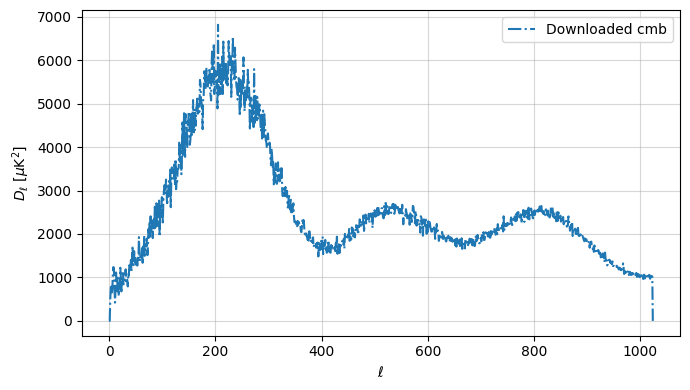

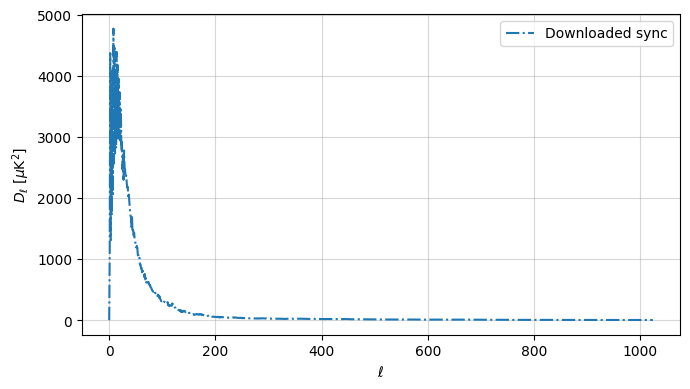

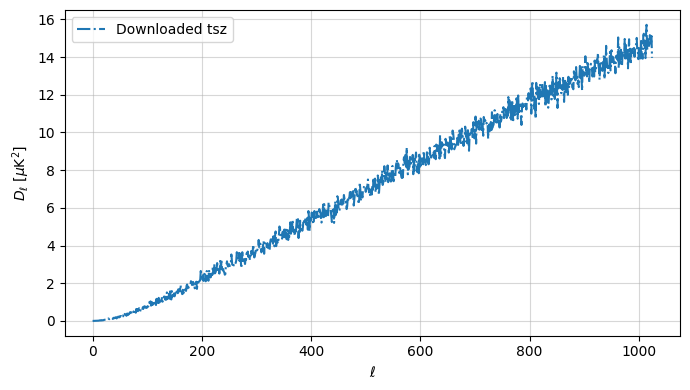

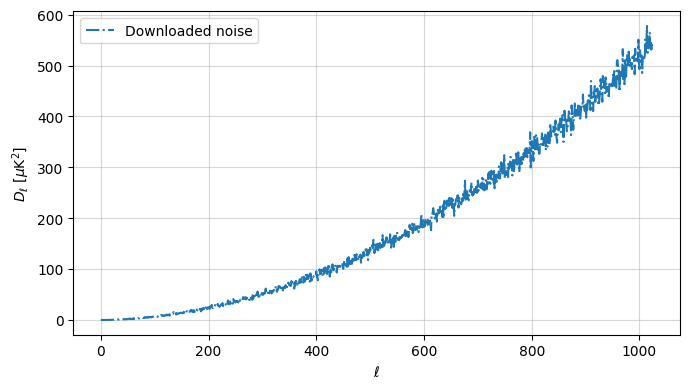

(array([   0,    1,    2, ..., 1022, 1023, 1024], shape=(1025,)),
 array([3.20548159e-09, 1.09573676e-14, 1.05003334e-14, ...,
        3.19325182e-15, 3.24545025e-15, 3.23123423e-15], shape=(1025,)))

In [10]:
lmax = 1024 
frequency = '030'

# 1) CMB (skyinbands; needs frequency)
pipe.step_power_spec(
    unit="K",
    source="downloaded",
    component="cmb",
    frequency=frequency,      # GHz
    lmax=lmax
)

# 2) Synchrotron (skyinbands; needs frequency)
pipe.step_power_spec(
    unit="K",
    source="downloaded",
    component="sync",
    frequency=frequency,      # GHz
    lmax=lmax
)

# 3) Thermal SZ (skyinbands; needs frequency)
pipe.step_power_spec(
    unit="K",
    source="downloaded",
    component="tsz",
    frequency=frequency,
    lmax=lmax
)

# 4) Instrument noise MC (needs frequency + realisation)
pipe.step_power_spec(
    unit="K",
    source="downloaded",
    component="noise",
    frequency=frequency,
    realisation=0,
    lmax=lmax
)


The power spectrum of the cfn = cmb + tsz + sync + noise

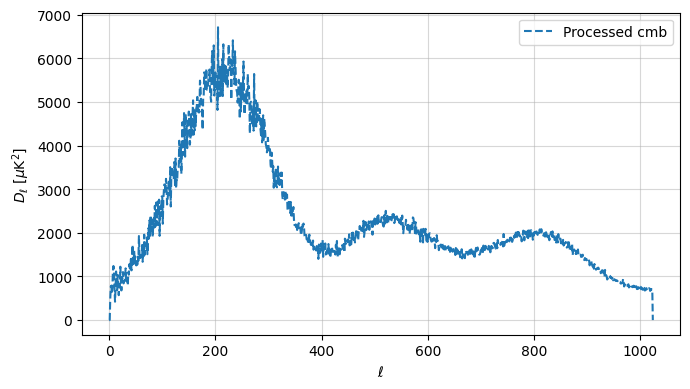

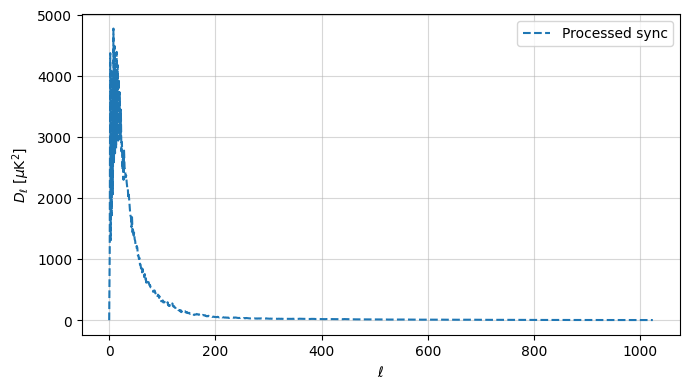

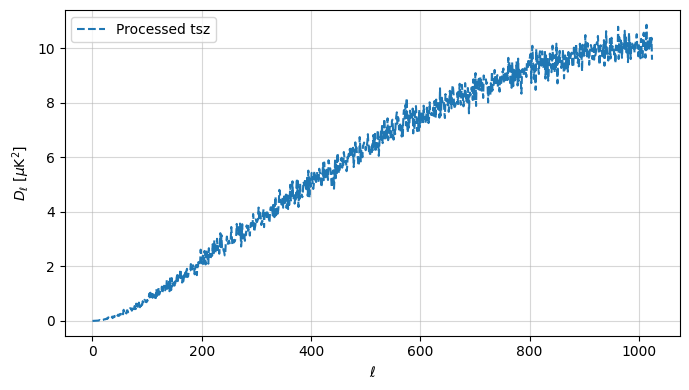

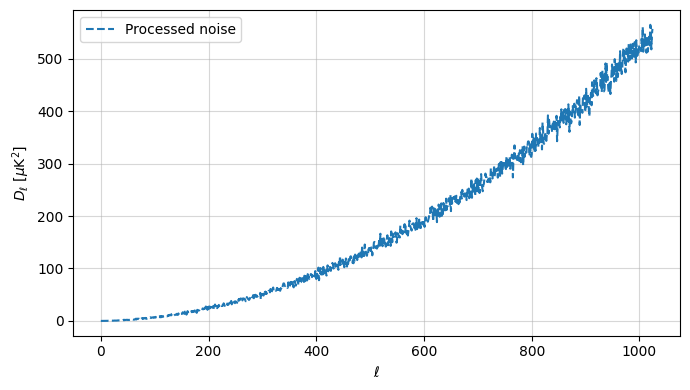

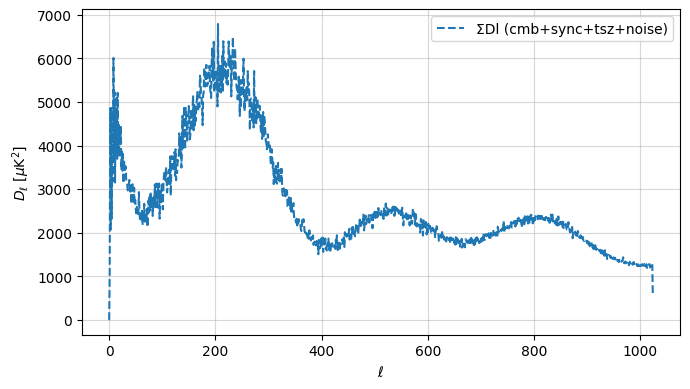

In [11]:
# --- sum of Dl from individual processed components (no alm math) ---

lmax = 1024
frequency = "030"

Dl_sum = None
ell_ref = None

def add_comp(comp, realisation=None):
    global Dl_sum, ell_ref
    ell, cl = pipe.step_power_spec(
        unit="K",
        source="processed",
        component=comp,
        frequency=frequency,
        realisation=realisation,
        lmax=lmax
    )
    Dl = PowerSpectrumTT.cl_to_Dl(ell, cl, input_unit="K")
    if Dl_sum is None:
        ell_ref = ell
        Dl_sum = Dl.copy()
    else:
        # assume same l-grid (same lmax) because we passed lmax explicitly
        Dl_sum += Dl

# 1) CMB
add_comp("cmb")
# 2) Synchrotron
add_comp("sync")
# 3) tSZ
add_comp("tsz")
# 4) Noise (specify realisation)
add_comp("noise", realisation=0)

# Plot the summed Dl
PowerSpectrumTT.plot_Dl_series([
    {"ell": ell_ref, "Dl": Dl_sum, "label": "ΣDl (cmb+sync+tsz+noise)", "source": "processed"}
])

# 'ell_ref' and 'Dl_sum' are r outputs


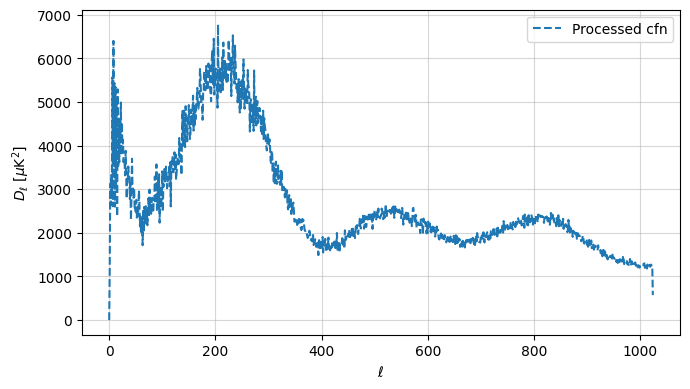

(array([   0,    1,    2, ..., 1022, 1023, 1024], shape=(1025,)),
 array([7.39764158e-08, 3.50927282e-09, 3.26943931e-09, ...,
        7.32134733e-15, 7.34900096e-15, 3.41283138e-15], shape=(1025,)))

In [12]:
lmax = 1024
pipe.step_power_spec(
    unit="K",
    source="processed",
    component="cfn",     
    frequency='030',       # GHz
    realisation=0,       # r00000
    lmax=lmax
)

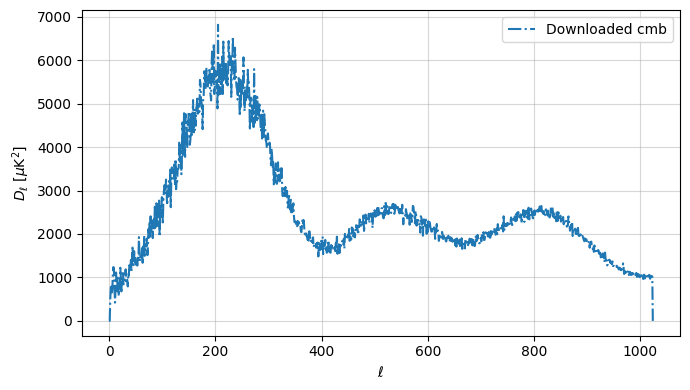

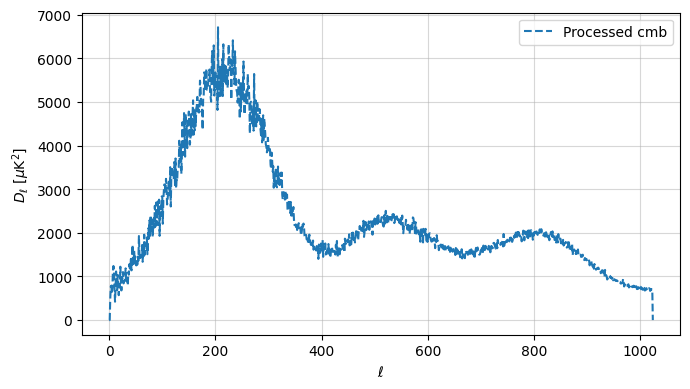

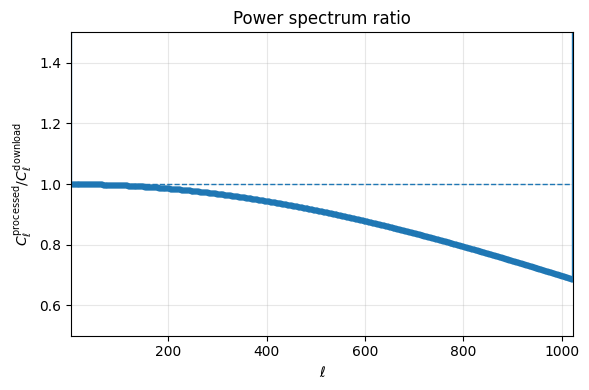

In [13]:
# --- same call you used ---
ell, cl = pipe.step_power_spec(
    unit="K",
    source="downloaded",
    component="cmb",
    frequency=frequency,      # GHz
    lmax=lmax
)


# --- call the 'processed' one with identical args ---
ell_proc, cl_proc = pipe.step_power_spec(
    unit="K",
    source="processed",
    component="cmb",
    extract_comp=None,
    frequencies=None,          # processed_cmb has no freq in filename
    realisation=0,
    lmax=1024,
    lam=2.0,
)

# --- ratio (processed over ilc_synth) ---
import numpy as np
import matplotlib.pyplot as plt

# (optional but helpful) ensure ℓ match
assert np.array_equal(ell, ell_proc), "ℓ grids differ"
ell = ell
ratio = cl_proc/ cl

# --- plot ---
plt.figure(figsize=(6,4))
plt.plot(ell, ratio, marker='.', linestyle='-')
plt.axhline(1.0, linestyle='--', linewidth=1)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell^{\mathrm{processed}} / C_\ell^{\mathrm{download}}$')
plt.ylim(0.5,1.5)
plt.xlim(2,1024)
plt.title('Power spectrum ratio')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show() 

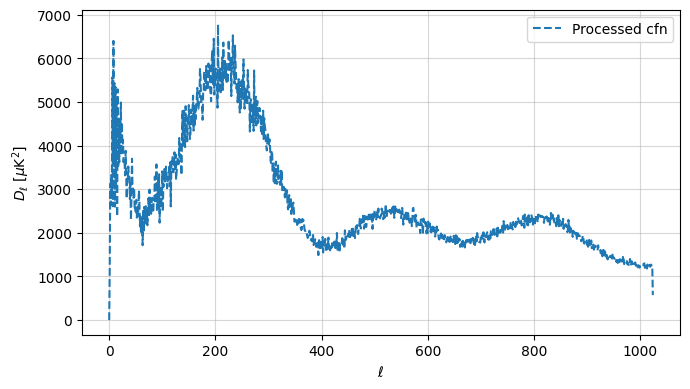

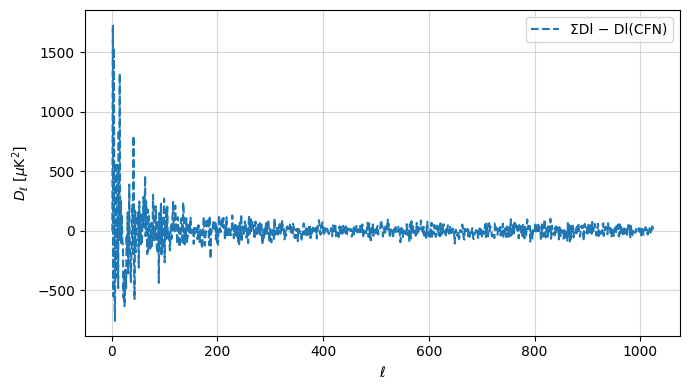

In [14]:
#  already have:
#   ell_ref, Dl_sum  (ΣDl of cmb+sync+tsz+noise at lmax=1024, frequency='030')

lmax = 1024
# CFN spectrum
ell_cfn, cl_cfn = pipe.step_power_spec(
    unit="K",
    source="processed",
    component="cfn",
    frequency="030",
    realisation=0,
    lmax=lmax
)
Dl_cfn = PowerSpectrumTT.cl_to_Dl(ell_cfn, cl_cfn, input_unit="K")

# residual = ΣDl(components) - Dl(CFN)
Dl_res = Dl_sum - Dl_cfn  

# plot residual
PowerSpectrumTT.plot_Dl_series([
    {"ell": ell_ref, "Dl": Dl_res, "label": "ΣDl − Dl(CFN)", "source": "processed"}
])


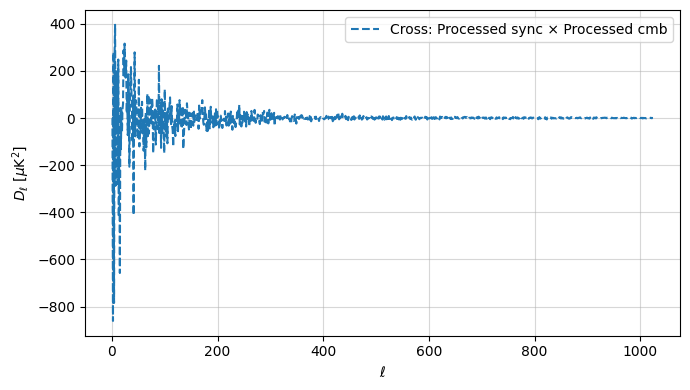

'\n# B) Cross ILC-synth (CMB target) with downloaded 143 GHz map\nell, Cl_xy = pipe.step_cross_power_spec(\n    source_X="ilc_synth", extract_comp_X="cmb", frequencies_X=["100","143","217"],  # your ILC set\n    source_Y="downloaded", component_Y="cmb", frequency_Y=143,                      # single band\n    lmax=3000\n)\n\n# C) Let it auto-pick sources (prefers \'processed\' if processed_cfn exists)\nell, Cl_xy = pipe.step_cross_power_spec(\n    source_X="auto",\n    source_Y="auto",\n    lmax=2048\n)\n'

In [ ]:
# A) Cross between two processed components (defaults pick 'cfn' if present)
ell, Cl_xy = pipe.step_cross_power_spec(
    source_X="processed", component_X="sync", frequency_X='030',
    source_Y="processed", component_Y="cmb", frequency_Y='030',
    lmax=1024,
    unit="K",                      # input C_ell in K^2; plot shows µK^2
    save_path=None                 # or "cross_processed_cfn_cmb.png"
)

'''
# B) Cross ILC-synth (CMB target) with downloaded 143 GHz map
ell, Cl_xy = pipe.step_cross_power_spec(
    source_X="ilc_synth", extract_comp_X="cmb", frequencies_X=["100","143","217"],  
    source_Y="downloaded", component_Y="cmb", frequency_Y=143,                      # single band
    lmax=3000
)

# C) Let it auto-pick sources (prefers 'processed' if processed_cfn exists)
ell, Cl_xy = pipe.step_cross_power_spec(
    source_X="auto",
    source_Y="auto",
    lmax=2048
)
'''

For every pair

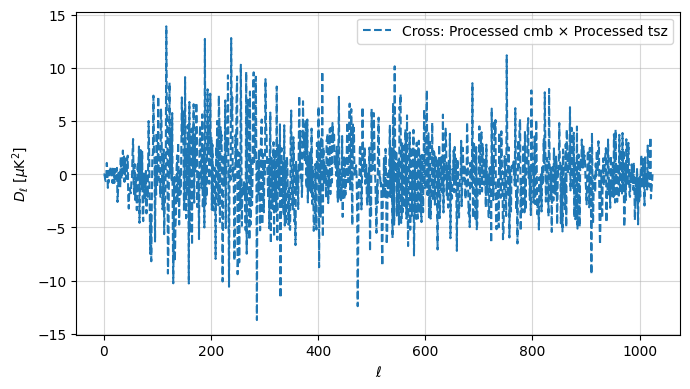

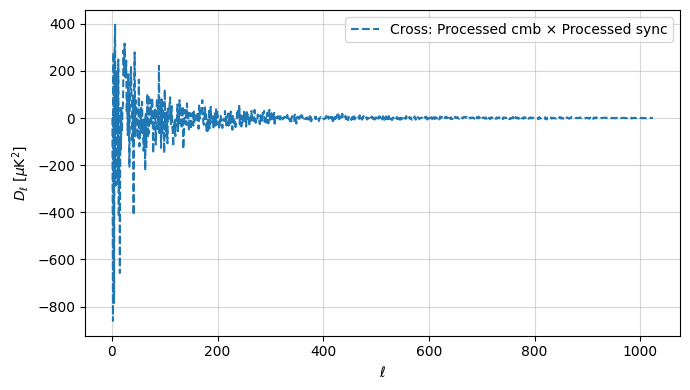

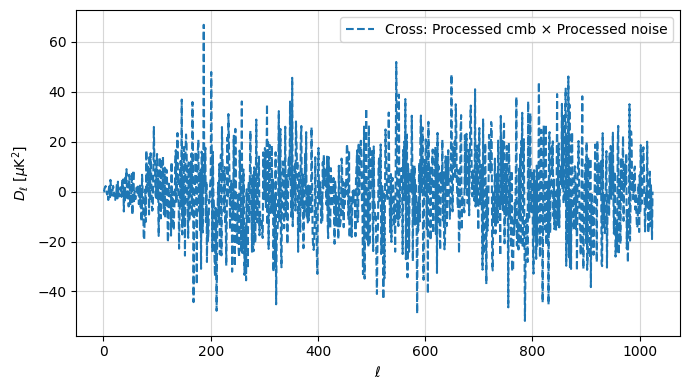

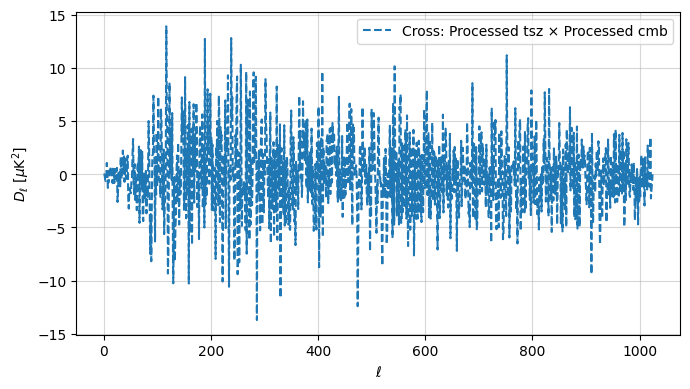

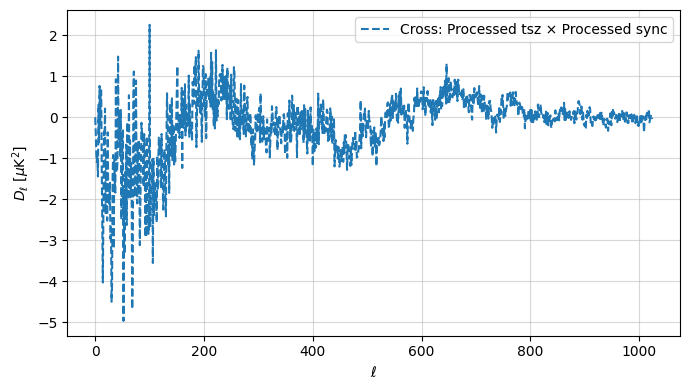

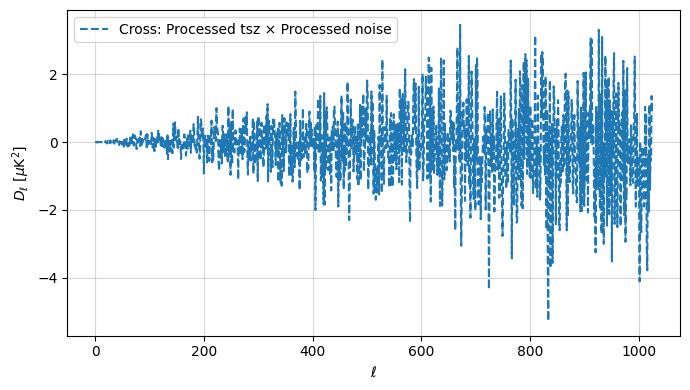

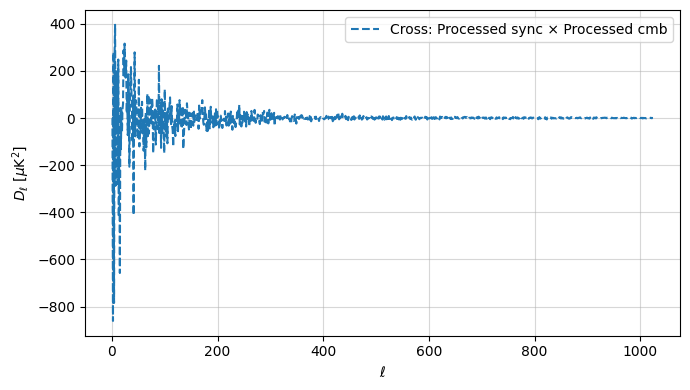

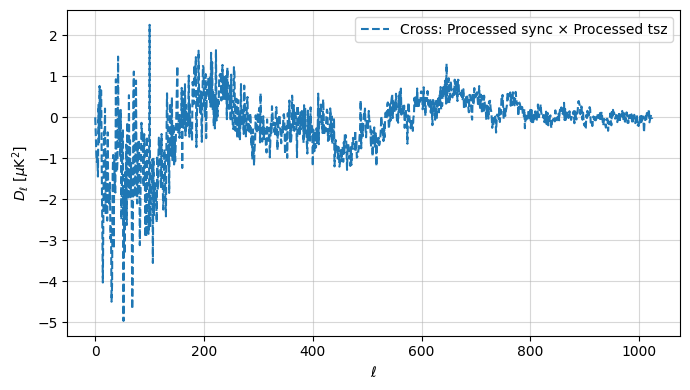

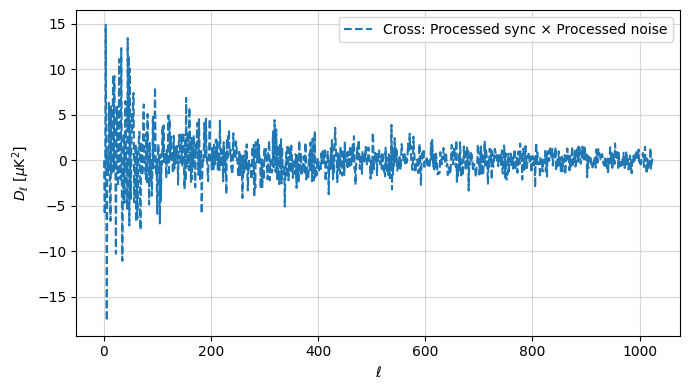

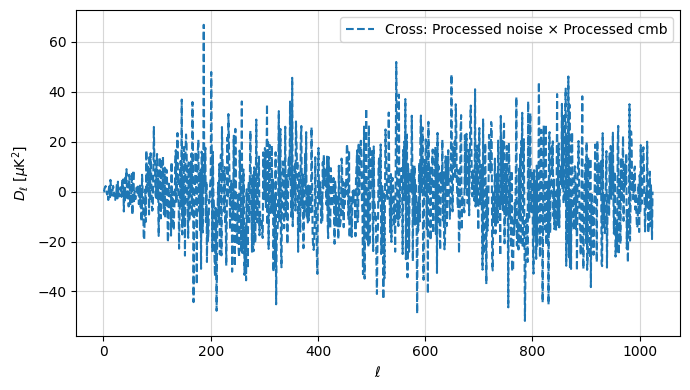

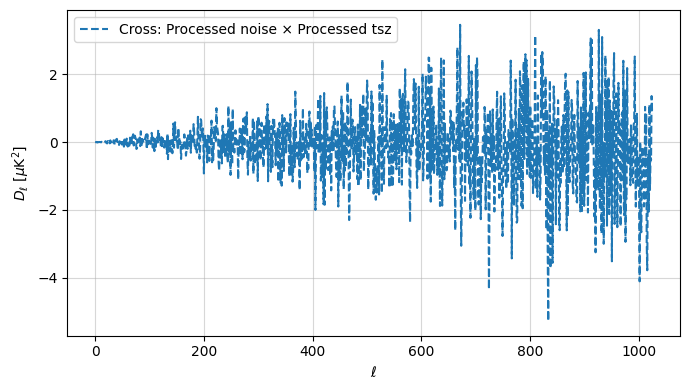

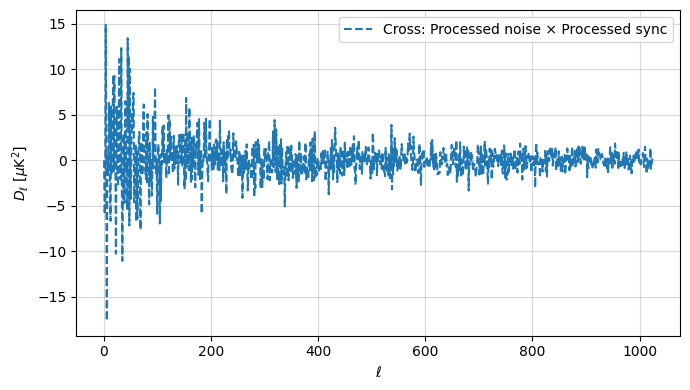

cmb × tsz :  C_0 = 5.1667e-16,  C_1 = -8.05884e-19
cmb × sync :  C_0 = -1.27612e-14,  C_1 = 3.4702e-18
cmb × noise :  C_0 = -3.79609e-18,  C_1 = 1.51955e-18
tsz × cmb :  C_0 = 5.1667e-16,  C_1 = -8.05884e-19
tsz × sync :  C_0 = -3.2512e-09,  C_1 = -1.21875e-12
tsz × noise :  C_0 = -9.67138e-13,  C_1 = -3.78849e-15
sync × cmb :  C_0 = -1.27612e-14,  C_1 = 3.4702e-18
sync × tsz :  C_0 = -3.2512e-09,  C_1 = -1.21875e-12
sync × noise :  C_0 = 2.38873e-11,  C_1 = -3.46125e-13
noise × cmb :  C_0 = -3.79609e-18,  C_1 = 1.51955e-18
noise × tsz :  C_0 = -9.67138e-13,  C_1 = -3.78849e-15
noise × sync :  C_0 = 2.38873e-11,  C_1 = -3.46125e-13


In [16]:
# build all pairs
components = ['cmb', 'tsz', 'sync', 'noise']
pairs = {}
for cx in components:
    for cy in components:
        if cx == cy:
            continue
        ell, Cl_xy = pipe.step_cross_power_spec(
            source_X="processed", component_X=cx, frequency_X='030',
            source_Y="processed", component_Y=cy, frequency_Y='030',
            lmax=1024, unit="K", save_path=None
        )
        pairs[(cx, cy)] = (ell, Cl_xy)

# check ℓ=0 and ℓ=1 for EVERY pair
for (cx, cy), (ell, Cl) in pairs.items():
    # assume ell[0]==0 and ell[1]==1; guard just in case
    cl0 = Cl[0] if ell.size > 0 and ell[0] == 0 else float('nan')
    cl1 = Cl[1] if ell.size > 1 and ell[1] == 1 else float('nan')
    print(f"{cx} × {cy} :  C_0 = {cl0:.6g},  C_1 = {cl1:.6g}")


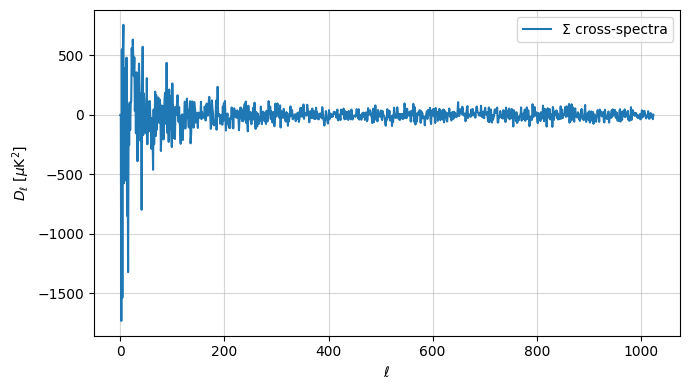

In [17]:
# Sum all cross spectra in `pairs` (built above), assuming all share the same ell
ell_sum = None
Cl_sum  = None

for (ell, Cl) in pairs.values():
    if ell_sum is None:
        ell_sum = ell
        Cl_sum  = np.zeros_like(Cl, dtype=np.float64)
    else:
        if ell.shape != ell_sum.shape or not np.all(ell == ell_sum):
            raise ValueError("Inconsistent ell arrays among pairs.")
    Cl_sum += Cl

# Optional: convert to D_ell (µK^2) and plot
Dl_sum = PowerSpectrumTT.cl_to_Dl(ell_sum, Cl_sum, input_unit="K")
PowerSpectrumTT.plot_Dl_series([(ell_sum, Dl_sum, "Σ cross-spectra", "-")], save_path=None, show=True)


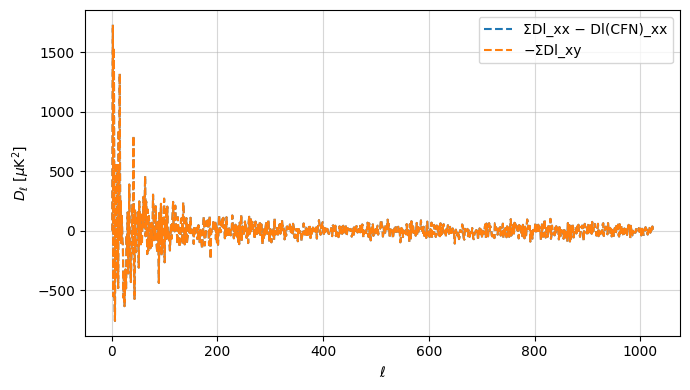

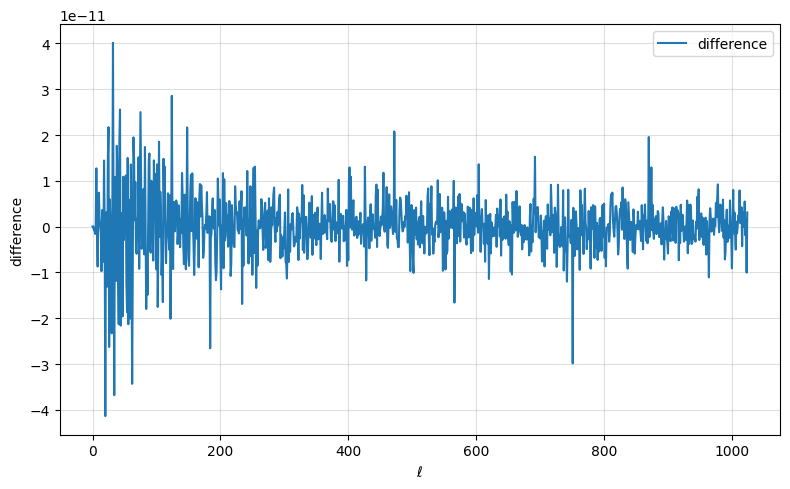

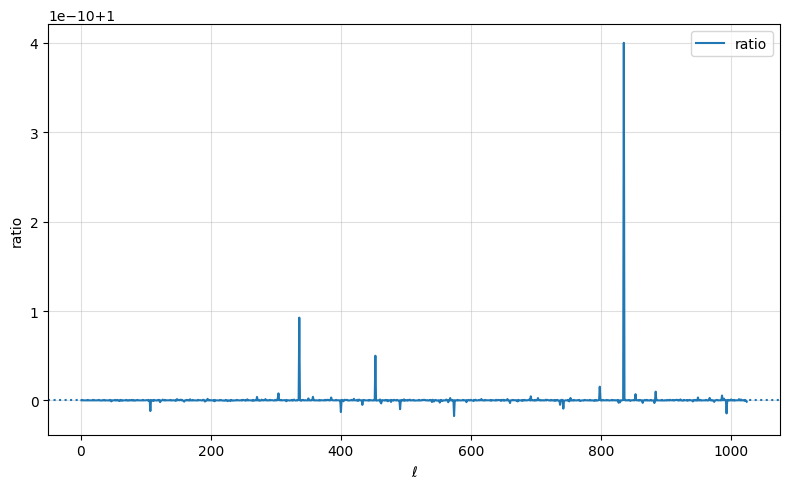

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Make sure ℓ match
if not np.array_equal(ell_ref, ell_cfn):
    raise ValueError("ell_ref and ell_cfn differ; align ℓ before comparing.")

# Negative of the whole sum
Dl_neg_whole = -Dl_sum

# Plot residual vs negative whole
PowerSpectrumTT.plot_Dl_series([
    {"ell": ell_ref, "Dl": Dl_res,       "label": "ΣDl_xx − Dl(CFN)_xx", "source": "processed"},
    {"ell": ell_ref, "Dl": Dl_neg_whole, "label": "−ΣDl_xy",          "source": "processed"},
], save_path=None, show=True)

# given: ell_ref, Dl_sum, Dl_res
Dl_neg = -Dl_sum

# difference and ratio (no epsilon; set ratio to NaN where denominator is zero)
diff  = Dl_res - Dl_neg
ratio = np.where(Dl_neg != 0, Dl_res / Dl_neg, np.nan)

# plots
plt.figure(figsize=(8,5))
plt.plot(ell_ref, diff, label="difference")
plt.xlabel(r"$\ell$"); plt.ylabel("difference"); plt.grid(True, alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(ell_ref, ratio, label="ratio")
plt.axhline(1.0, linestyle=":")
plt.xlabel(r"$\ell$"); plt.ylabel("ratio"); plt.grid(True, alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()


In [19]:
pipe.step_wavelets()

--- PRODUCING WAVELET TRANSFORMS ---
Device 0: bytes_in_use=0 peak_bytes_in_use=0 bytes_limit=19069206528 largest_free_chunk=n/a num_allocs=0
Wavelet coefficients for cfn at 030 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 030 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 044 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 044 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 070 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 070 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 100 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 100 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 143 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 143 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 217 GHz for realisation 0 already exist. Skipp

In [20]:
import os

ft = FileTemplates(directory="/Scratch/agnes/data")

# Pick which to inspect ( can include both)
dirs = [
    ft.output_directories["wavelet_coeffs"],   # per-scale directional wavelet maps
    ft.output_directories["scaling_coeffs"],   # scaling (low-pass) maps
]

for d in dirs:
    print(f"\n{d}:")
    if not os.path.exists(d):
        print("  (does not exist)")
        continue
    try:
        entries = sorted(os.listdir(d))
    except PermissionError as e:
        print(f"  (permission error) {e}")
        continue

    if not entries:
        print("  (empty)")
    else:
        for name in entries:
            print("  ", name)


/Scratch/agnes/data/wavelet_transforms/wavelet_coeffs:
   cfn_recon_f030_lmax128_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax1024_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax1028_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax124_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax128_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax128_lam2.5.npy
   cfn_wavelet_f030_s0_r00000_lmax128_lam3.0.npy
   cfn_wavelet_f030_s0_r00000_lmax256_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax264_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax265_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax512_lam2.0.npy
   cfn_wavelet_f030_s0_r00000_lmax64_lam2.0.npy
   cfn_wavelet_f030_s10_r00000_lmax1024_lam2.0.npy
   cfn_wavelet_f030_s10_r00000_lmax1028_lam2.0.npy
   cfn_wavelet_f030_s10_r00000_lmax256_lam2.0.npy
   cfn_wavelet_f030_s10_r00000_lmax264_lam2.0.npy
   cfn_wavelet_f030_s10_r00000_lmax265_lam2.0.npy
   cfn_wavelet_f030_s10_r00000_lmax512_lam2.0.npy
   cfn_wavelet_f030_s11_r00000_lmax1024_lam2.0.npy
   cfn_wavelet

1
number of wavelet bands J: 8
2
3
scaling shape: (128, 255)
4
band shape: (1, 128, 255)
length of bands: 8
5
6
7


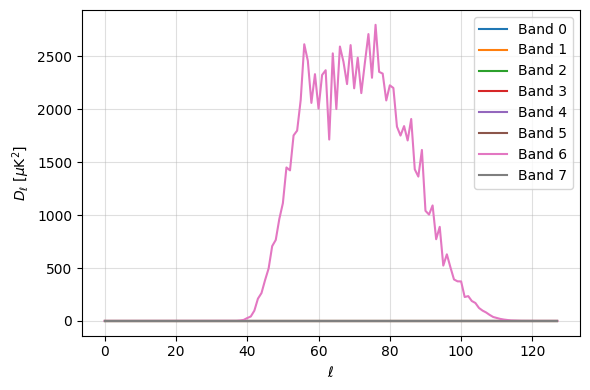

In [21]:
import numpy as np

freq        = "030"
scale       = 7        
realisation = 0
lmax        = 1024
lam         = 2.0
root        = "/Scratch/agnes/data/wavelet_transforms/wavelet_coeffs"


path = f"{root}/cfn_wavelet_f{freq}_s{scale}_r{realisation:05d}_lmax{lmax}_lam{lam}.npy"
w_band = np.load(path)

L = w_band.shape[0] if w_band.ndim == 2 else w_band.shape[1]

mw_alm = MWTools.wavelet_to_mw_alm(
    w_band,
    L=L,
    N_directions=1,
    lam=lam,
    reality=False,
    band_index=scale-1,  
)


1
number of wavelet bands J: 9
2
3
scaling shape: (256, 511)
4
band shape: (1, 256, 511)
length of bands: 9
5
6
7


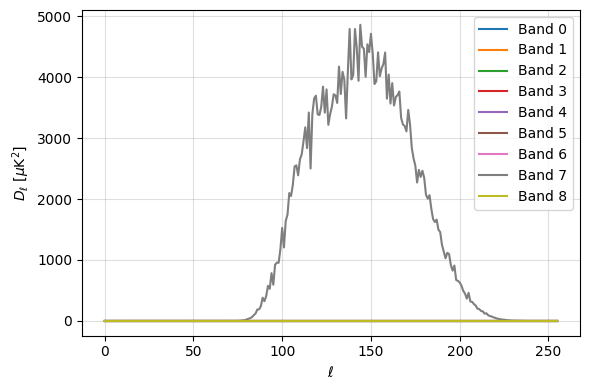

In [ ]:
import numpy as np
import jax.numpy as jnp
import s2fft
import s2wav
import s2wav.filters as filters

# --- inputs ---
freq        = "030"
scale       = 8                 # disk s{scale} -> band_index = scale-1
realisation = 0
lmax        = 1024
lam         = 2.0
root        = "/Scratch/agnes/data/wavelet_transforms/wavelet_coeffs"

# --- 1) per-band spectrum C_ell^{(j)} from single-band recon at its native L_band ---
path_band = f"{root}/cfn_wavelet_f{freq}_s{scale}_r{realisation:05d}_lmax{lmax}_lam{lam}.npy"
w_band = np.load(path_band)                                # e.g. (256, 511) for s8
L_band = w_band.shape[0] if w_band.ndim == 2 else w_band.shape[1]

mw_alm_band = MWTools.wavelet_to_mw_alm(                   # <-- use L_band here
    w_band,
    L=L_band,
    N_directions=1,
    lam=lam,
    reality=False,
    band_index=scale-1,  
)
ell, Cj = PowerSpectrumTT.from_mw_alm(mw_alm_band)         # C_ell^{(j)}

# --- 2) total spectrum C_ell^{tot} ---
# IMPORTANT: saved coeffs are multi-resolution, so don't try to synthesize all s1..sJ
# together at L_full in one call (they have different shapes). Instead, get C_tot from a full map
# already have, or from a previously computed full-resolution alm/map.

# If already have the full map or alm at lmax+1:
#   alm_full = ...  # (compute or load once at L_full = lmax+1)
#   ell_full, C_tot_full = PowerSpectrumTT.from_mw_alm(alm_full)
#   C_tot = C_tot_full[:L_band]  # truncate to match Cj's band-limit

# If DON'T have it handy, compare to theory |kappa|^2 directly:

# --- 3) theory |kappa|^2 from the SAME filters used in visualiser (at L_band) ---
wav_filters_band, scal_filter_band = filters.filters_directional_vectorised(L=L_band, N=1, lam=lam)
m0 = L_band - 1
psi_l0 = np.array(wav_filters_band[scale-1, :, m0])
kappa2 = (4.0*np.pi / (2.0*ell + 1.0)) * np.abs(psi_l0)**2


In [23]:
# 1) Band-only spectrum from your reconstructed mw_alm
ell_band, cl_band = PowerSpectrumTT.from_mw_alm(mw_alm)   # C_ell^{(j)}
# (Optional, identical ratio if you use Dl instead of Cl)
Dl_band = PowerSpectrumTT.cl_to_Dl(ell_band, cl_band, input_unit="K")

# 2) Align totals to the band's ell-range (multi-resolution!)
L_band = len(ell_band)            # should equal your L above
Cl_tot_use = cl_cfn[:L_band]
Dl_tot_use = Dl_cfn[:L_band]

# 3) Per-ℓ ratio (this is the per-band ratio you want)
Cl_ratio = cl_band / (Cl_tot_use)
Dl_ratio = Dl_band / (Dl_tot_use)   # numerically the same as Cl_ratio

# (Optional) quick sanity
# assert np.array_equal(ell_band, ell_cfn[:L_band])
print("mean ratio:", Cl_ratio.mean())


mean ratio: 0.29710281385986775


alpha (LS) = 1,  alpha (median) = 5.87996,  RMS residual = 1.907e+00


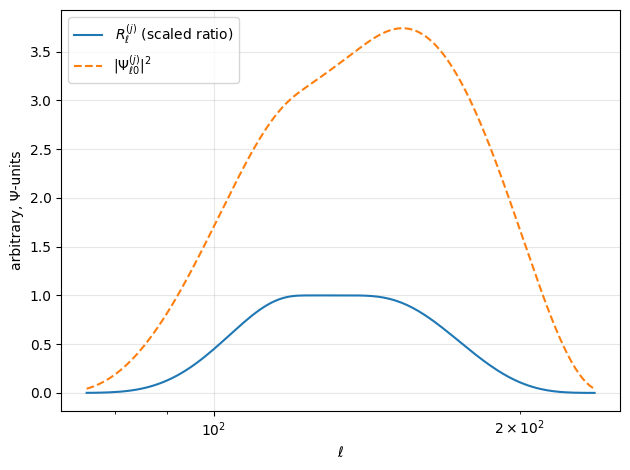

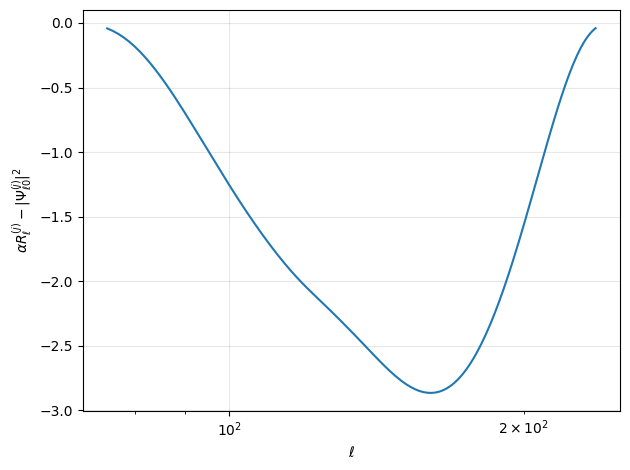

In [27]:
ell_band, cl_band = PowerSpectrumTT.from_mw_alm(mw_alm_band)   # C_ell^(j)
L_band = len(ell_band)
R = cl_band / (cl_cfn[:L_band] + 1e-30)                        # per-ℓ band ratio

# --- get the SAME filter curve (axisym, N=1) in 'visualiser' units ---
wav_filters, scal_filter = filters.filters_directional_vectorised(L=L_band, N=1, lam=lam)
j  = scale - 1
m0 = L_band - 1
psi_sq = np.abs(np.array(wav_filters[j, :, m0]))**2            # |Ψ^j_{ℓ0}|^2 (no extra factor)

# --- restrict to the passband (avoid tiny tails) ---
mask = psi_sq > (0.01 * psi_sq.max())

# --- fit a single scale α so that α*R ≈ |Ψ|^2 on the passband ---
# least-squares α = argmin ||α R - ψ||^2  ->  α = (R·ψ)/(R·R)
R_in  = R[mask]
P_in  = psi_sq[mask]
alpha_ls = 1

# (robust alternative: median-of-ratios)
alpha_med = np.median(P_in / (R_in))

# pick one (LS by default)
alpha = alpha_ls

# --- diagnostics ---
resid = alpha*R_in - P_in
rms   = np.sqrt(np.mean(resid**2))
print(f"alpha (LS) = {alpha_ls:.6g},  alpha (median) = {alpha_med:.6g},  RMS residual = {rms:.3e}")

# --- plot ---
plt.figure()
plt.semilogx(ell_band[mask], alpha*R_in, label=r"$\,R_\ell^{(j)}$ (scaled ratio)")
plt.semilogx(ell_band[mask], P_in,       "--", label=r"$|\Psi^{(j)}_{\ell0}|^2$")
plt.xlabel(r"$\ell$"); plt.ylabel("arbitrary, Ψ-units"); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()

# optional residual plot
plt.figure()
plt.semilogx(ell_band[mask], resid)
plt.xlabel(r"$\ell$"); plt.ylabel(r"$\alpha R_\ell^{(j)} - |\Psi_{\ell0}^{(j)}|^2$"); plt.grid(alpha=0.3); plt.tight_layout()
